# Purpose

With a hybrid hub, we expect two distinct forms of cell-cell interaction, along the CCR7 axis and along the IFNG axis. Can we see this in cells? 


In [2]:
suppressPackageStartupMessages({
    ## This is my custom library for various helper functions for spatial pre-processing 
    # devtools::install_github('korsunskylab/spatula', dependencies = FALSE)    
    # devtools::install_github('korsunskylab/spatula')
    library(harmony)
    library(uwot)
    library(singlecellmethods)
    library(sfarrow)
    library(geojsonsf)
    library(sf)    
    library(spatula)
    library(purrr)
    library(furrr)
    library(circlize)
    library(ComplexHeatmap)
    library(ggrepel)
    library(future)
    library(scales)
    library(glue)
    library(data.table)
    library(spatstat)
    library(dplyr)
    library(data.table)
    library(presto)
    library(ggplot2)
    library(ggthemes)
    library(patchwork)
    library(Matrix)
})

fig.size <- function(h, w) {
    options(repr.plot.height = h, repr.plot.width = w)
}

source('utils_plotting.R')
source('utils.R')


# Data

## Cells

In [2]:
cells = list(
    # meta_data = fread('/n/data1/bwh/medicine/korsunsky/lab/ik97/NirMerfish/lung_n4/cells/meta_data.csv'), ## wrong hubIDs
    meta_data = fread('share/cells/meta_data.csv'), ## correct hubIDs
    counts = spatula::readMM('/n/data1/bwh/medicine/korsunsky/lab/ik97/NirMerfish/lung_n4/cells/counts.mtx')
)

cells$meta_data$cell <- as.character(cells$meta_data$cell)
rownames(cells$counts) <- readLines('/n/data1/bwh/medicine/korsunsky/lab/ik97/NirMerfish/lung_n4/cells/genes.txt')
colnames(cells$counts) <- cells$meta_data$cell
# U <- readRDS('/n/data1/bwh/medicine/korsunsky/lab/ik97/NirMerfish/lung_n4/cells/U.rds')
cells$U2 <- readRDS('/n/data1/bwh/medicine/korsunsky/lab/ik97/NirMerfish/lung_n4/cells/U2.rds')

cells$markers_lvl1 = fread('/n/data1/bwh/medicine/korsunsky/lab/ik97/NirMerfish/lung_n4/cells/markers_lvl1.csv')
cells$markers_lvl2 = fread('/n/data1/bwh/medicine/korsunsky/lab/ik97/NirMerfish/lung_n4/cells/markers_lvl2.csv')


## Balanced immune TNK/Myeloid UMAP 
cells$U3 = readRDS('/n/data1/bwh/medicine/korsunsky/lab/ik97/NirMerfish/lung_n4/cells_immune/U3.rds')

## Hubs

In [3]:
hubs = readRDS('lung_n4/grid/obj_hubs.rds')


In [4]:
dim(hubs$counts)

[1]  479 1916

In [5]:
head(hubs$meta_data)

Registered S3 method overwritten by 'geojson':
  method        from     
  print.geojson geojsonsf



,library,hubType,ID,ntiles,X,Y,area,shape
,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<GEOMETRY>
1,Sample05,tumor,1,6381,7156.300,2177.3111,15874262.765,MULTIPOLYGON (((3800.149 18...
2,Sample05,tumor,2,1,8286.479,941.4254,2500.000,POLYGON ((8259.615 925.9153...
3,Sample05,tumor,3,57,10452.114,2271.2108,142500.018,MULTIPOLYGON (((10274.43 22...
4,Sample05,tumor,4,1,10301.298,2383.8630,2500.000,POLYGON ((10274.43 2368.353...
5,Sample05,tumor,5,2,10583.372,1988.3559,5000.001,POLYGON ((10569.94 1980.601...
6,Sample05,tumor,6,27,10906.241,1136.1631,67500.009,POLYGON ((10704.26 1065.506...


## attach hub info to cell

In [6]:
cells$meta_data = cells$meta_data %>% 
    left_join(
        data.table(st_drop_geometry(hubs$meta_data))[, .(hubID = paste0('H', ID), hubType)]
    )


Joining with `by = join_by(hubID, hubType)`


# Neighborhood composition

If I am an mreg DC


Get Delaunay neighbors 


## explore delaunay adj mat for each lib

In [7]:
unique(cells$meta_data$library)

[1] "Patient001" "Patient002" "Sample04"   "Sample05"

In [8]:
.SD = cells$meta_data[
    type_lvl2 != '' & hubType == 'hybrid_hub' & library == 'Sample04' & 
    TRUE
]

coords = .SD[, .(X, Y)]
y = .SD$type_lvl2
index_type = 'LAMP3+CCL19+ mreg DC'


In [9]:
cells$meta_data[
    type_lvl2 != '' & hubType == 'hybrid_hub', 
    data.table(t(data.table(quantile(spatula::getSpatialNeighbors(.SD[, .(X, Y)], return_weights = TRUE)@x, c(.05, .95, .99))))), 
    by = library
]

library,V1,V2,V3
<chr>,<dbl>,<dbl>,<dbl>
Patient001,5.549047,23.40766,65.64666
Patient002,5.617922,27.54618,119.82496
Sample04,7.089111,46.77711,114.75227
Sample05,6.184739,22.97792,64.83787


In [10]:
types = unique(y)
i_index = which(y == index_type)
i_shuffle = setdiff(seq_len(nrow(coords)), i_index)
adj = spatula::getSpatialNeighbors(coords, return_weights = TRUE)


In [11]:
# adj@x[adj@x > 30] = 0
# adj = Matrix::drop0(adj)

Most distances are within 5-23 microns. 

In [12]:
mean(adj@x)
quantile(adj@x, c(.05, .95))


[1] 17.65411

5%       95% 
 7.089111 46.777113

But there are outliers! 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


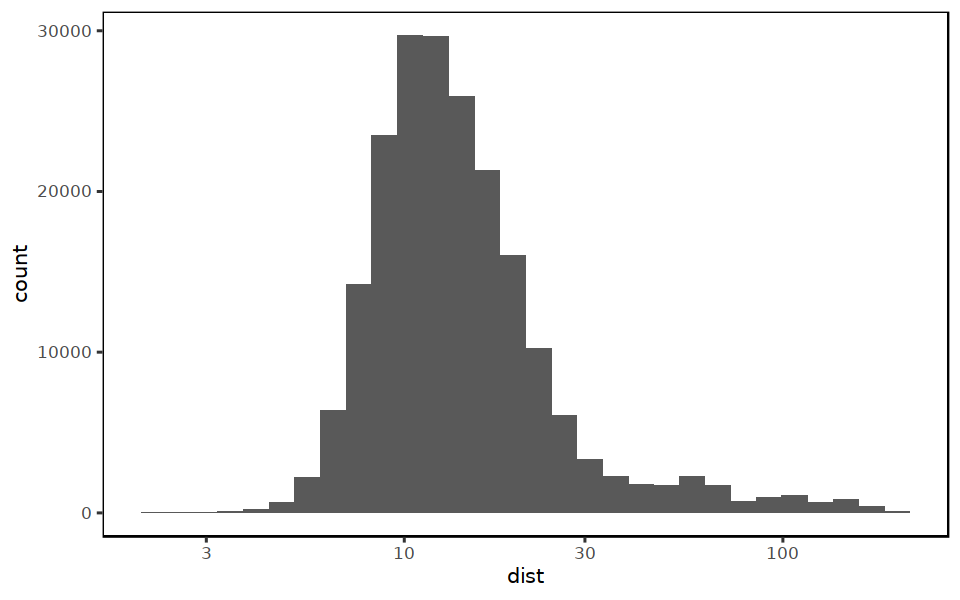

In [13]:
fig.size(5, 8)
tibble(dist = adj@x) %>% ggplot(aes(dist)) + geom_histogram() + scale_x_log10()


## function

In [14]:
## By default, only keep the mean and SD of permutation distribution
##   If save_perms=TRUE, keep all the values 
bar = function(index_type, adj, y, nperm = 100, max_dist=30, compartments=NULL, verbose=TRUE, save_perms=FALSE) {
    if (verbose) message(index_type)
    types = unique(y)
    i_index = which(y == index_type)
    i_shuffle = setdiff(seq_len(length(y)), i_index)

    X = adj[i_index, ] %*% Matrix::sparse.model.matrix(~0+y) %>% as.matrix() 
    colnames(X) = gsub('^y', '', colnames(X))
    freq = (colSums(X) / nrow(X))[types]
    freq_perm = map(seq_len(nperm), function(i) {
        set.seed(i)
        yperm = y
        if (is.null(compartments)) {
            yperm[i_shuffle] = sample(y[i_shuffle])
        } else {
            ## shuffle inside compartments, to preserve total composition within compartment
            .x = split(i_shuffle, compartments[i_shuffle]) %>% 
                map(function(.i) {
                    ## CAUTION: if .i is a single number, sample will interpret it as 1:.i
                    if (length(.i) == 1) {
                        res = .i
                    } else {
                        res = sample(.i) ## shuffle non-index cells inside hub             
                    }
                    
                    names(res) = .i
                    return(res)
                }) %>% 
                reduce(c)
            yperm[as.integer(names(.x))] <- y[.x]
        }

        X = adj[i_index, ] %*% Matrix::sparse.model.matrix(~0+yperm) %>% as.matrix() #%>% prop.table(1)
        colnames(X) = gsub('^yperm', '', colnames(X))
        (colSums(X) / nrow(X))[types]    
    }) %>% 
        purrr::reduce(rbind2)

    stats = tibble(
        type = types, 
        freq, 
        zscore = (freq - apply(freq_perm, 2, mean)) / apply(freq_perm, 2, sd), 
        pval = exp(pnorm(-zscore, log.p = TRUE, lower.tail = TRUE)), ## one-tailed
        fdr = p.adjust(pval)
    ) %>% 
        cbind(dplyr::rename(data.frame(t(apply(freq_perm, 2, quantile, c(.025, .975)))), q025 = `X2.5.`, q975 = `X97.5.`)) %>% ## 95% CI
        subset(type != index_type) %>% 
        dplyr::mutate(index_type = index_type) %>% 
        dplyr::select(index_type, type, everything()) %>% 
        arrange(fdr)
    
    if (save_perms) {
        stats$freq_perm = asplit(freq_perm[, stats$type, drop = FALSE], 2)
    }

    return(stats)    
}


In [15]:
foo = function(index_types, coords, y, nperm = 100, max_dist=30, compartments=NULL, parallel=TRUE, verbose=TRUE, save_perms=FALSE) {
    if (parallel & length(index_types) > 1) {
        plan(multicore)
    } else {
        plan(sequential)
    }

    adj = spatula::getSpatialNeighbors(coords, return_weights = TRUE)
    adj@x[adj@x > max_dist] = 0
    adj = Matrix::drop0(adj)
    adj@x = rep(1, length(adj@x))
    
    ## map over index types 
    index_types %>% 
        future_map(bar, adj, y, nperm, max_dist, compartments, verbose, save_perms, .options = furrr::furrr_options(seed = 1)) %>% 
        rbindlist()  
}


## meta-analysis over libraries and hub types

### Compute stats

In [17]:
# .SD = cells$meta_data[
#     library %in% 'Patient001' & 
#     type_lvl2 %in% c('B', 'Treg', 'CD8 T') #, 'NK', 'CD4 T', 'CD8 T')
# ][
#     type_lvl2 != '' & hubType == 'hybrid_hub'
# ]

In [18]:
# foo(unique(.SD$type_lvl2), .SD[, .(X, Y)], .SD$type_lvl2, nperm = 10, max_dist = 30, compartments = NULL, parallel = FALSE, verbose = TRUE)

Might take ~1 hour? 

In [ ]:
system.time({
    res = cells$meta_data[
        ## SUBSET FOR TESTING 
        # library %in% c('Patient001') & 
        # type_lvl2 %in% c('B', 'Treg', 'LAMP3+CCL19+ mreg DC') #, 'NK', 'CD4 T', 'CD8 T')
        # type_lvl2 %in% c('Epithelial', 'SPP1+ Macrophage', 'MMP1+SOX4+ Myeloid')
    ][
        # type_lvl2 != '' & hubType %in% c('hybrid_hub')
        type_lvl2 != '' ## do all hub types! 
        # type_lvl2 != '' & hubType %in% c('hybrid_hub', 'immune_hub')
    ][
        # , unique(.SD[, hubID]), 
        , foo(index_types = unique(.SD$type_lvl2), coords = .SD[, .(X, Y)], y = .SD$type_lvl2, nperm = 1000, max_dist = 30, compartments = .SD$hubID, parallel = TRUE, verbose = TRUE, save_perms = TRUE), 
        # , foo(index_types = unique(.SD$type_lvl2), coords = .SD[, .(X, Y)], y = .SD$type_lvl2, nperm = 20, max_dist = 30, compartments = .SD$hubID, parallel = TRUE, verbose = TRUE, save_perms = TRUE), 
        # , foo(index_types = unique(.SD$type_lvl2), coords = .SD[, .(X, Y)], y = .SD$type_lvl2, nperm = 20, max_dist = 30, compartments = .SD$hubID, parallel = TRUE, verbose = TRUE), 
        # , foo(unique(.SD$type_lvl2), .SD[, .(X, Y)], .SD$type_lvl2, nperm = 10, max_dist = 30, compartments = NULL, parallel = TRUE, verbose = TRUE), 
        # , foo(unique(.SD$type_lvl2), .SD[, .(X, Y)], .SD$type_lvl2, nperm = 10, max_dist = 30, compartments = .SD, parallel = FALSE, verbose = TRUE), 
        by = .(library, hubType)
    ]
})


In [ ]:
pryr::object_size(res)


In [ ]:
res %>% map(pryr::object_size)

### Cache

In [29]:
fwrite(res, '/n/data1/bwh/medicine/korsunsky/lab/ik97/NirMerfish/data/colocalization_stats.csv')

In [3]:
res = fread('/n/data1/bwh/medicine/korsunsky/lab/ik97/NirMerfish/data/colocalization_stats.csv')
library(stringr)
if ('freq_perm' %in% colnames(res)) {
    res$freq_perm = res$freq_perm %>% str_split('\\|') %>% map(as.numeric)    
}


In [ ]:
# res[hubType == 'hybrid_hub' & grepl('mreg', index_type)][, .(library, hubType, index_type, type, zscore, pval)] %>% 
res[hubType == 'immune_hub' & grepl('CXCL10', index_type) & grepl('CD8', type)][, .(library, hubType, index_type, type, zscore, pval)] %>% 
res[hubType == 'hybrid_hub' & grepl('CXCL10', index_type) & grepl('CD8', type)][, .(library, hubType, index_type, type, zscore, pval)] %>% 
# res[hubType == 'hybrid_hub' & grepl('CXCL10', index_type) & grepl('CD8', type)][, .(library, hubType, index_type, type, zscore, pval)] %>% 
# res[hubType == 'hybrid_hub' & grepl('mreg', index_type)][, .(library, hubType, index_type, type, zscore, pval)] %>% 
    split(.$type)


### Recompute frequency in log space - z scores are different? 

In [62]:
# cells$meta_data[
#     library == 'Patient001' & grepl('hybrid', hubType)
# ][, .N, by = type_lvl2][order(N)]

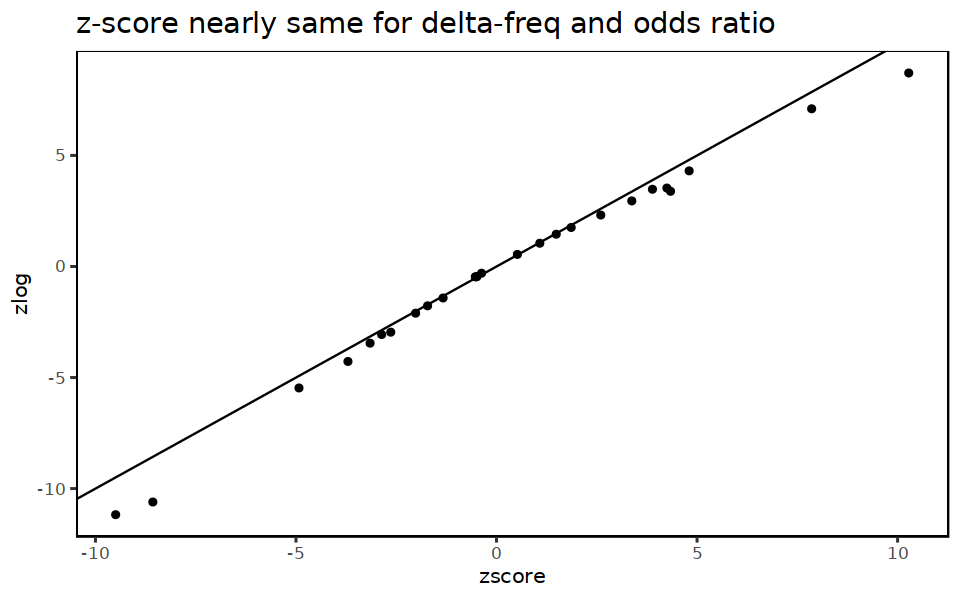

In [96]:
fig.size(5, 8)
res[hubType == 'hybrid_hub' & library == 'Patient001' & index_type == t1][
    , zlog := (log(freq) - mean(log(unlist(.SD$freq_perm)))) / sd(log(unlist(.SD$freq_perm))), by = type
][] %>% 
    ggplot(aes(zscore, zlog)) + 
        geom_point() + 
        geom_abline() + 
        labs(title = 'z-score nearly same for delta-freq and odds ratio') + 
        NULL


In [89]:
# t1 = 'CXCL10+ Macrophage'
t1 = 'LAMP3+CCL19+ mreg DC'
# t2 = 'CD8 T'
# t2 = 'CD4 T'
# t2 = 'Treg'
# t2 = 'TCF7+ CD8 T'


fig.size(5, 8)
.SD = res[hubType == 'hybrid_hub' & library == 'Patient001' & index_type == t1 & type == t2] 



.SD$freq / mean(unlist(.SD$freq_perm))
.SD$freq - mean(unlist(.SD$freq_perm))


(log(.SD$freq) - mean(log(unlist(.SD$freq_perm)))) / sd(log(unlist(.SD$freq_perm)))
(.SD$freq - mean(unlist(.SD$freq_perm))) / sd(unlist(.SD$freq_perm))


[1] 1.034111

[1] 0.005292299

[1] 0.5445059

[1] 0.5197769

In [33]:
.SD$freq / mean(unlist(.SD$freq_perm))

[1] 1.376047

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 8 rows containing non-finite values (`stat_bin()`).”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 6 rows containing non-finite values (`stat_bin()`).”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 53 rows containing non-finite values (`stat_bin()`).”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 44 rows containing non-finite values (`stat_bin()`).”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 3 rows containing non-finite values (`stat_bin()`).”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 59 rows containing non-finite values (`stat_bin()`).”
Warning message:
“Transformatio

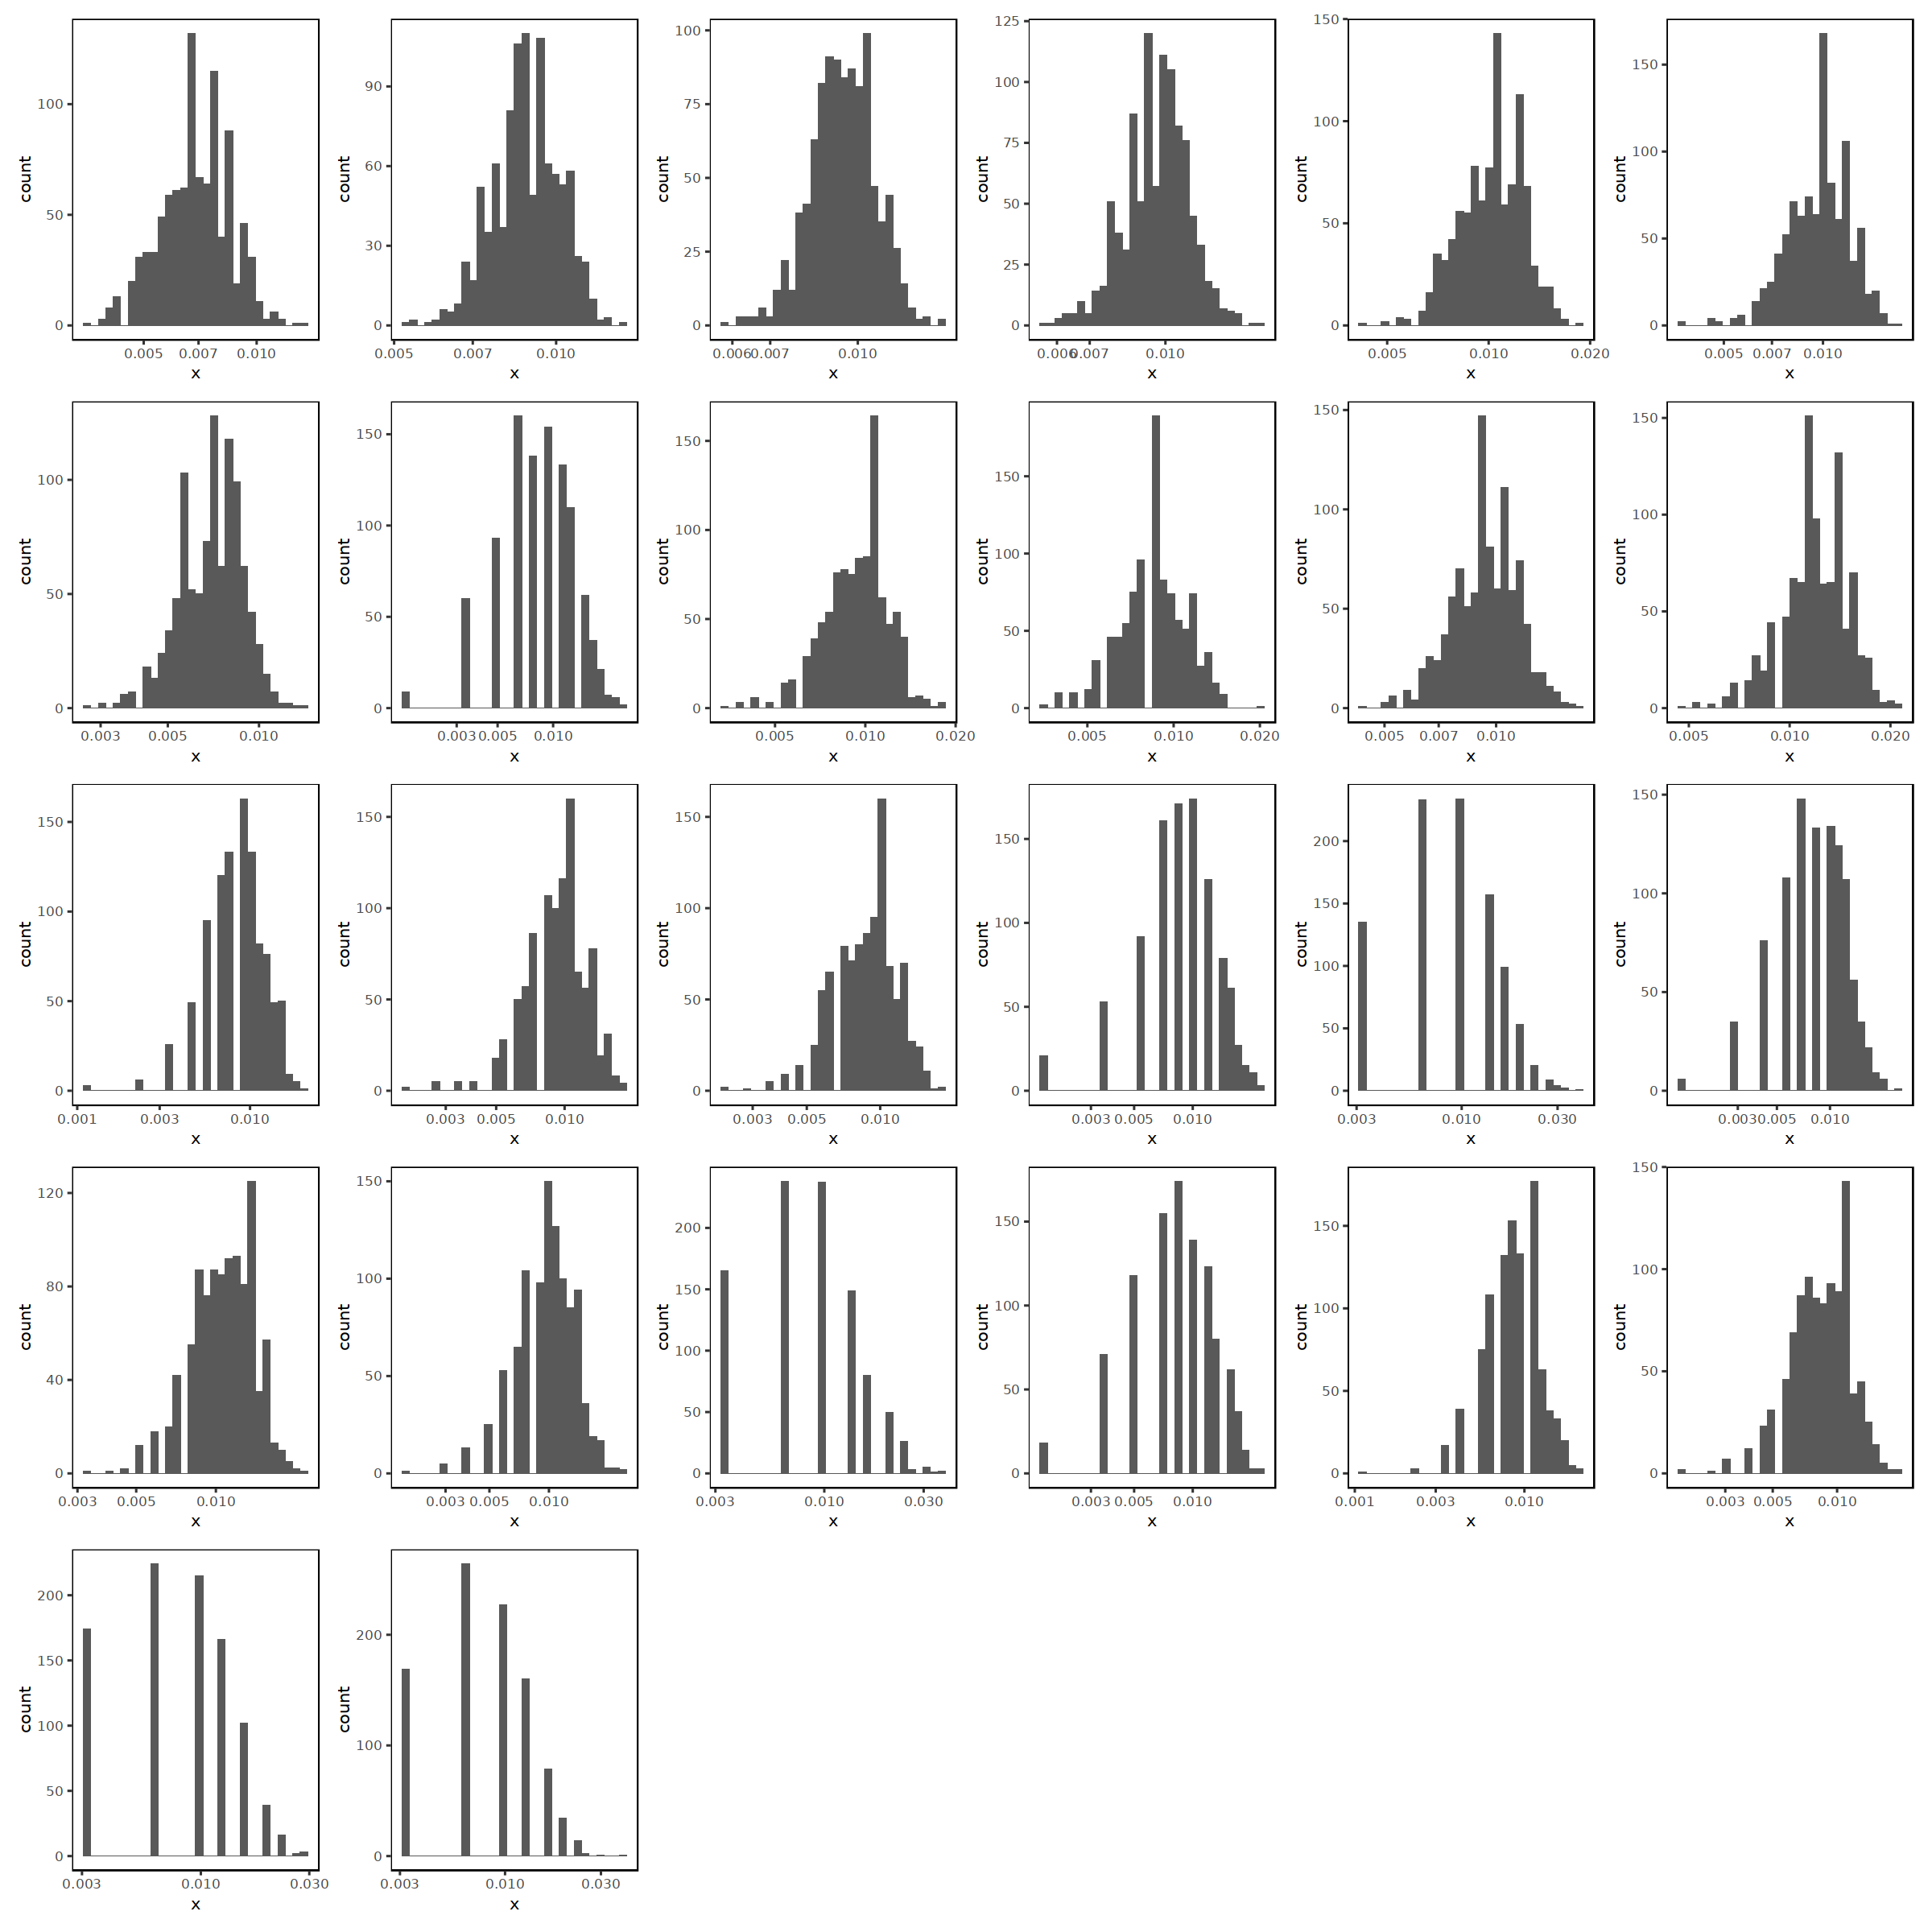

In [59]:
fig.size(20, 20)
res[library == 'Patient001' & hubType == 'hybrid_hub' & grepl('NK', type)] %>% 
    asplit(1) %>% 
    map(function(.SD) {
        ggplot() + 
            geom_histogram(
                data = tibble(x = unlist(.SD$freq_perm)), 
                aes(x),
                bins = 30
            ) + 
            scale_x_log10() + 
            # theme_void() + 
            NULL
        
    }) %>% 
    reduce(`+`)


### Histograms

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwid

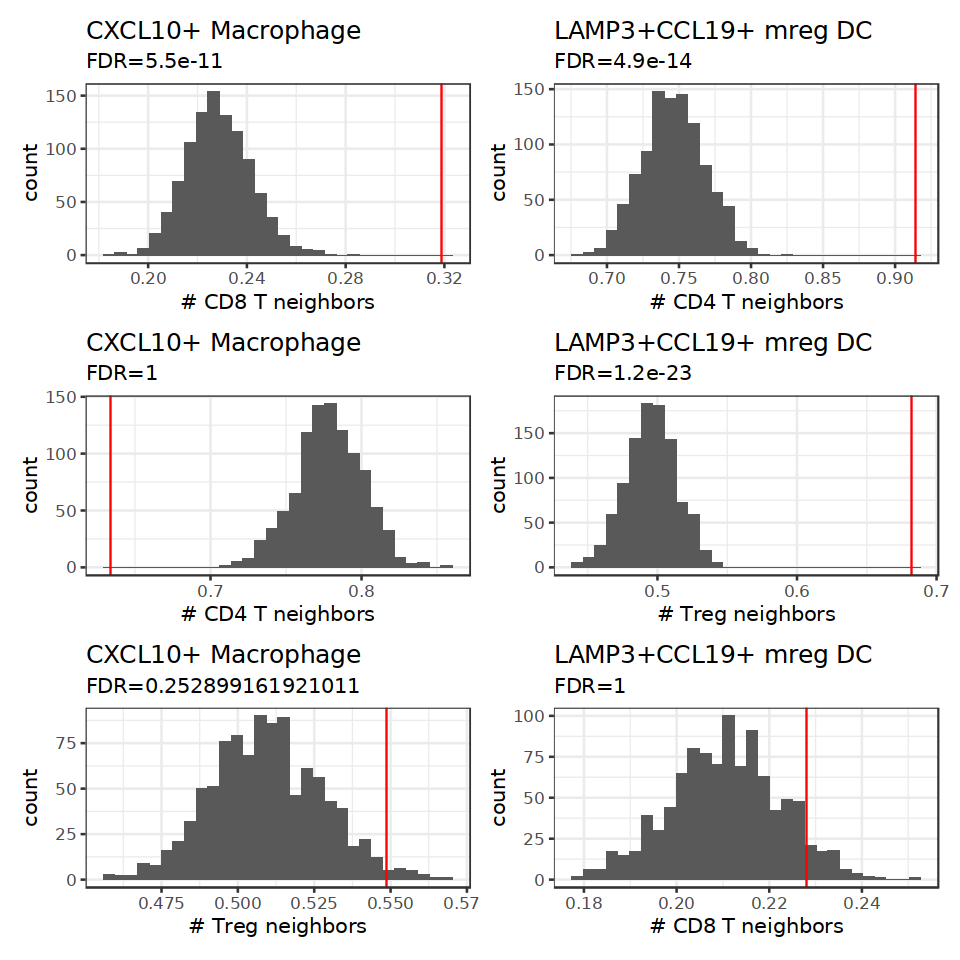

In [7]:
foo = function(t1, t2) {
    .SD = res[hubType == 'hybrid_hub' & library == 'Patient001' & index_type == t1 & type == t2] 
    if (.SD$fdr < .001) {
        .subtitle = glue('FDR={base::format(.SD$fdr, scientific=TRUE, digits=2)}')
    } else {
        .subtitle = glue('FDR={.SD$fdr}')
    }
    
    ggplot() + 
        geom_histogram(
            data = tibble(x = unlist(.SD$freq_perm)), 
            aes(x)
        ) + 
        geom_vline(
            data = tibble(x = .SD$freq), aes(xintercept = x), color = 'red'
        ) + 
        labs(
            # title = 'Permutation Distribution', subtitle = .SD$library, 
            title = glue('{.SD$index_type}'), 
            subtitle = .subtitle, 
            x = glue('# {.SD$type} neighbors')
            # x = glue('#{.SD$type} near a {.SD$index_type}')
        ) + 
        # scale_x_log10() + 
        theme_bw(base_size = 12) + 
        NULL
}

fig.size(8, 8)
(
    (
        foo('CXCL10+ Macrophage', 'CD8 T') /
        foo('CXCL10+ Macrophage', 'CD4 T') / 
        foo('CXCL10+ Macrophage', 'Treg') 
    ) 
) | 
(
    foo('LAMP3+CCL19+ mreg DC', 'CD4 T') / 
    foo('LAMP3+CCL19+ mreg DC', 'Treg') / 
    foo('LAMP3+CCL19+ mreg DC', 'CD8 T')
) + 
plot_annotation(tag_levels = 'a')

ggsave('figures/Null_distributions.pdf', device = 'pdf', units = 'in', height = 8, width = 8)
ggsave('figures/Null_distributions.png', device = 'png', units = 'in', height = 8, width = 8)


In [117]:
# fig.size(8, 8)
# t1 = 'LAMP3+CCL19+ mreg DC'
# t2 = 'Treg'
# .SD = res[hubType == 'hybrid_hub' & index_type == t1 & type == t2] 
# .SD %>% 
#     asplit(1) %>% 
#     imap(function(x, name) {
#         ggplot() + 
#             geom_histogram(
#                 data = tibble(x = unlist(x$freq_perm)), 
#                 aes(x)
#             ) + 
#             geom_vline(
#                 data = tibble(x = x$freq), aes(xintercept = x), color = 'red'
#             ) + 
#             labs(
#                 # title = 'Permutation Distribution', subtitle = .SD$library, 
#                 subtitle = glue('{.SD$index_type}'), 
#                 x = glue('# {.SD$type} neighbors')
#                 # x = glue('#{.SD$type} near a {.SD$index_type}')
#             ) + 
#             # scale_x_log10() + 
#             theme_bw(base_size = 12) + 
#             NULL
#     }) %>% 
#     reduce(`+`)


In [116]:
# fig.size(5, 8)
# .SD %>% 
#     tidyr::unnest(freq_perm) %>% 
#     ggplot() + 
#         geom_density(aes(freq_perm, fill = library)) + 
#         # geom_histogram(aes(freq_perm, fill = library)) + 
#         geom_vline(aes(xintercept = freq, color = library)) + 
#         scale_fill_tableau() + 
#         scale_color_tableau() + 
#         NULL


In [11]:
libs = unique(res$library)
for (lib in libs) {
    lib <<- lib
    foo = function(t1, t2) {
        .SD = res[hubType == 'hybrid_hub' & library == lib & index_type == t1 & type == t2] 
        if (.SD$fdr < .01) {
            .subtitle = glue('FDR={base::format(.SD$fdr, scientific=TRUE, digits=2)}')
        } else {
            .subtitle = glue('FDR={base::format(.SD$fdr, digits=2)}')
        }
        ggplot() + 
            geom_histogram(
                data = tibble(x = unlist(.SD$freq_perm)), 
                aes(x), 
                bins = 30
            ) + 
            geom_vline(
                data = tibble(x = .SD$freq), aes(xintercept = x), color = 'red'
            ) + 
            labs(
                # title = 'Permutation Distribution', subtitle = .SD$library, 
                # subtitle = glue('{.SD$index_type}'), 
                title = glue('{.SD$index_type}'), 
                subtitle = .subtitle, 
                x = glue('# {.SD$type} neighbors')
                # x = glue('#{.SD$type} near a {.SD$index_type}')
            ) + 
            # scale_x_log10() + 
            theme_bw(base_size = 12) + 
            NULL
    }

    fig.size(8, 8)
    (
        (
            foo('CXCL10+ Macrophage', 'CD8 T') /
            foo('CXCL10+ Macrophage', 'CD4 T') / 
            foo('CXCL10+ Macrophage', 'Treg') 
        ) 
    ) | 
    (
        foo('LAMP3+CCL19+ mreg DC', 'CD4 T') / 
        foo('LAMP3+CCL19+ mreg DC', 'Treg') / 
        foo('LAMP3+CCL19+ mreg DC', 'CD8 T')
    ) + 
    plot_annotation(tag_levels = 'a')

    ggsave(glue('figures/Null_distributions_{lib}.pdf'), device = 'pdf', units = 'in', height = 8, width = 8)
    ggsave(glue('figures/Null_distributions_{lib}.png'), device = 'png', units = 'in', height = 8, width = 8)

}


### Heatmaps

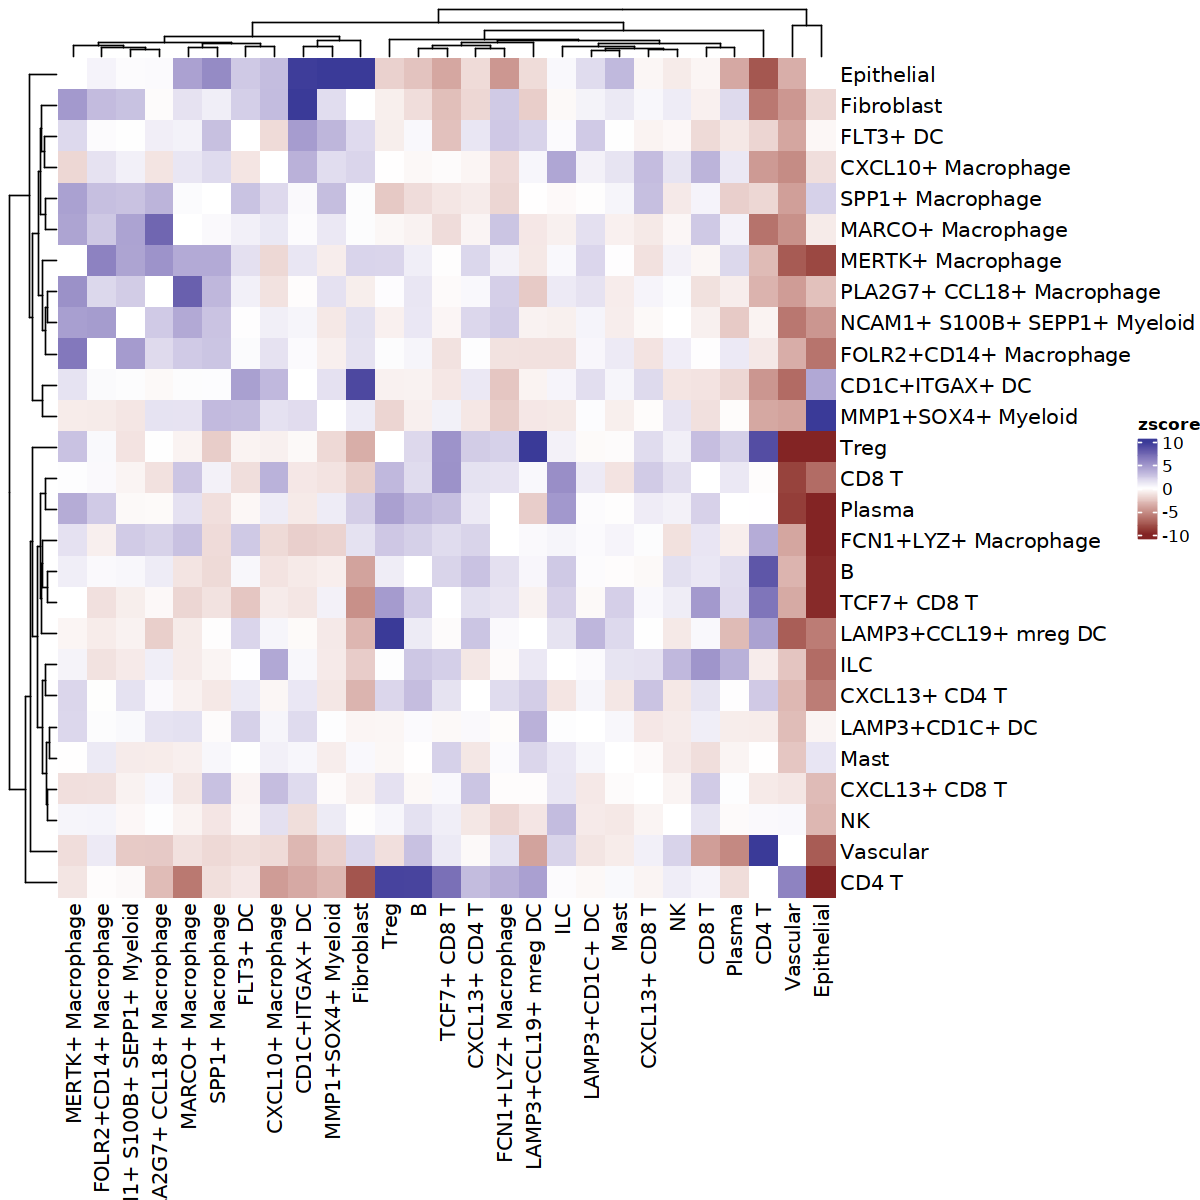

In [46]:
fig.size(10, 10)
X = res[library == 'Patient002' & hubType == 'hybrid_hub'][, .(index_type, type, zscore)] %>%
# X = res[library == 'Patient002' & hubType == 'immune_hub'][, .(index_type, type, zscore)] %>%
# X = res[library == 'Patient001' & hubType == 'hybrid_hub'][, .(index_type, type, zscore)] %>%
    data.frame() %>% 
    tidyr::spread(type, zscore, fill = 0) %>% 
    tibble::column_to_rownames('index_type') %>% 
    as.matrix() 

Heatmap(
    matrix = X, 
    name = 'zscore',
    col = colorRamp2(c(-10, 0, 10), c(muted('red'), 'white', muted('blue'))),
    column_title = ''
    # col = colorRamp2(c(-10, 0, 10), c('white', 'white', muted('blue')))        
    # col = colorRamp2(c(-max(X), 0, max(X)), c('white', 'white', muted('blue')))        
)


### Summarize stats

Interesting things: 
- Sample04 seems really off: we may have misclassified hubs in this dataset 
- Tregs are next to CXCL10+ macs in immunity hubs but not in hybrid hubs


In [4]:
res_meta = res[
    , .(freq = mean(freq), zscore = mean(zscore)), 
    , by = .(index_type, type, hubType)
][
    # , pval := exp(pnorm(-zscore, log.p = TRUE, lower.tail = FALSE)), ## two-tailed    
    , pval := exp(pnorm(-zscore, log.p = TRUE, lower.tail = TRUE)), ## one-tailed    
][
    , fdr := p.adjust(pval)
][]

head(res_meta)

index_type,type,hubType,freq,zscore,pval,fdr
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Epithelial,MARCO+ Macrophage,tumor,0.128887794,6.6505048,1.0000000,1
Epithelial,MMP1+SOX4+ Myeloid,tumor,0.038458860,19.3273559,1.0000000,1
Epithelial,Vascular,tumor,0.120708132,12.7090603,1.0000000,1
Epithelial,LAMP3+CD1C+ DC,tumor,0.018717809,8.9370823,1.0000000,1
Epithelial,SPP1+ Macrophage,tumor,0.134005933,0.9595995,0.8313716,1
Epithelial,CXCL13+ CD8 T,tumor,0.007010505,2.5462444,0.9945556,1


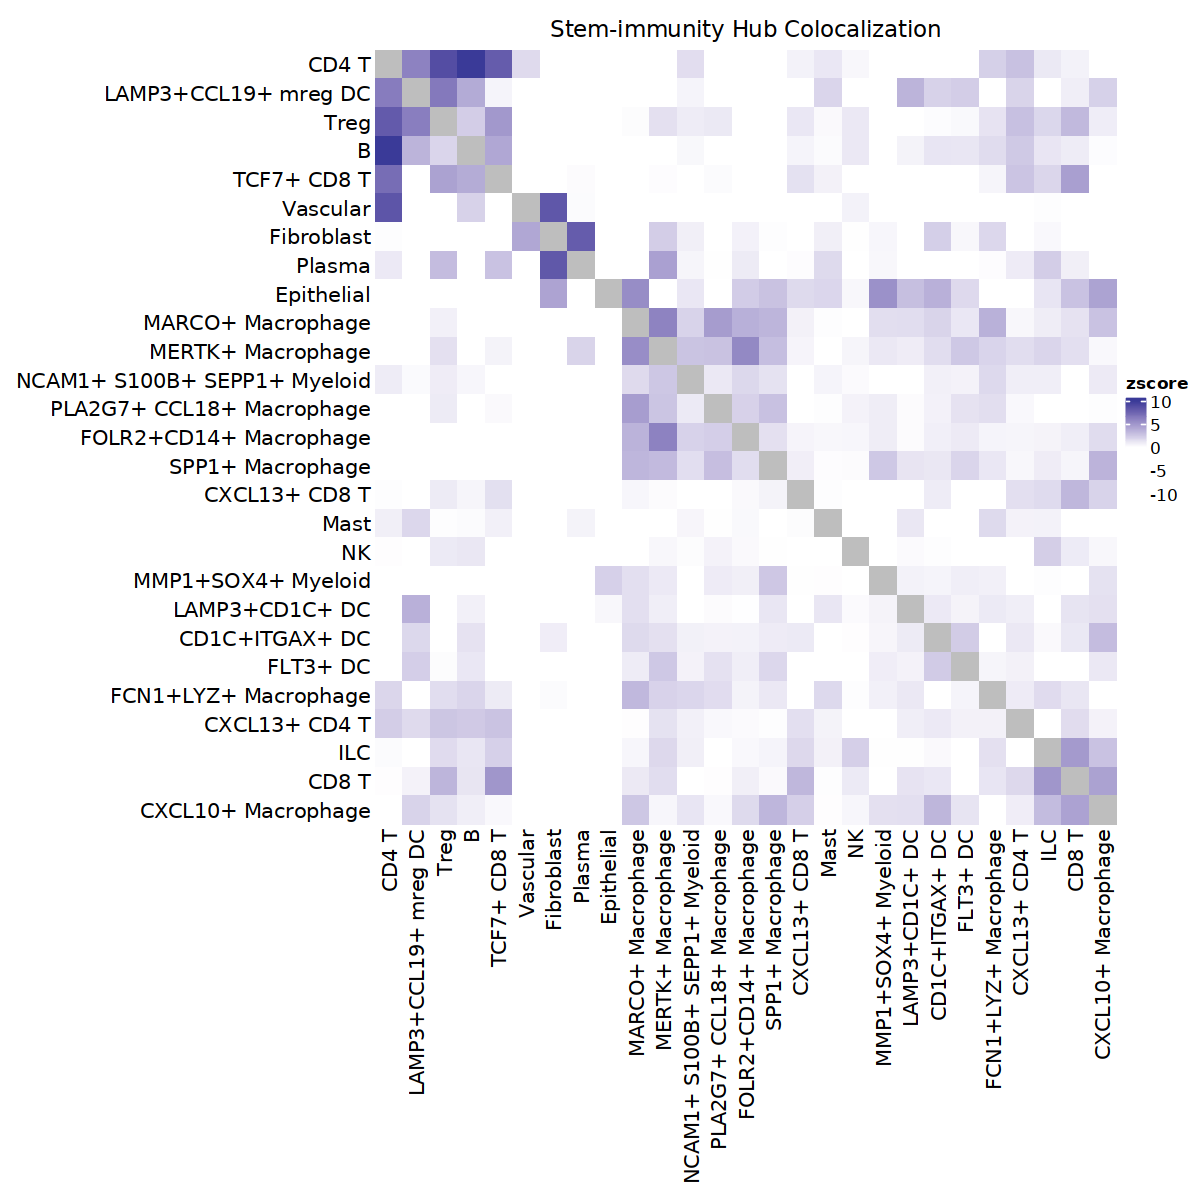

In [122]:
fig.size(10, 10)
X = res_meta[hubType == 'hybrid_hub'][, .(index_type, type, zscore)] %>%
    data.frame() %>% 
    tidyr::spread(type, zscore, fill = NA) %>% 
    tibble::column_to_rownames('index_type') %>% 
    as.matrix() 

X = pmin(X, 10)
o = hclust(dist(X))$order

plt = Heatmap(
    matrix = X[o, o], 
    cluster_columns = FALSE, cluster_rows = FALSE, 
    name = 'zscore',
    col = colorRamp2(c(-10, 0, 10), c('white', 'white', muted('blue'))),
    column_title = 'Stem-immunity Hub Colocalization',
    row_names_side = 'left'
)

plt <- grid.grabExpr(
    draw(
        plt, 
        padding = unit(c(15, 15, 2, 2), "mm"), #bottom, left, top, right paddings
    )    
) 
plt <- wrap_elements(plt)
plt


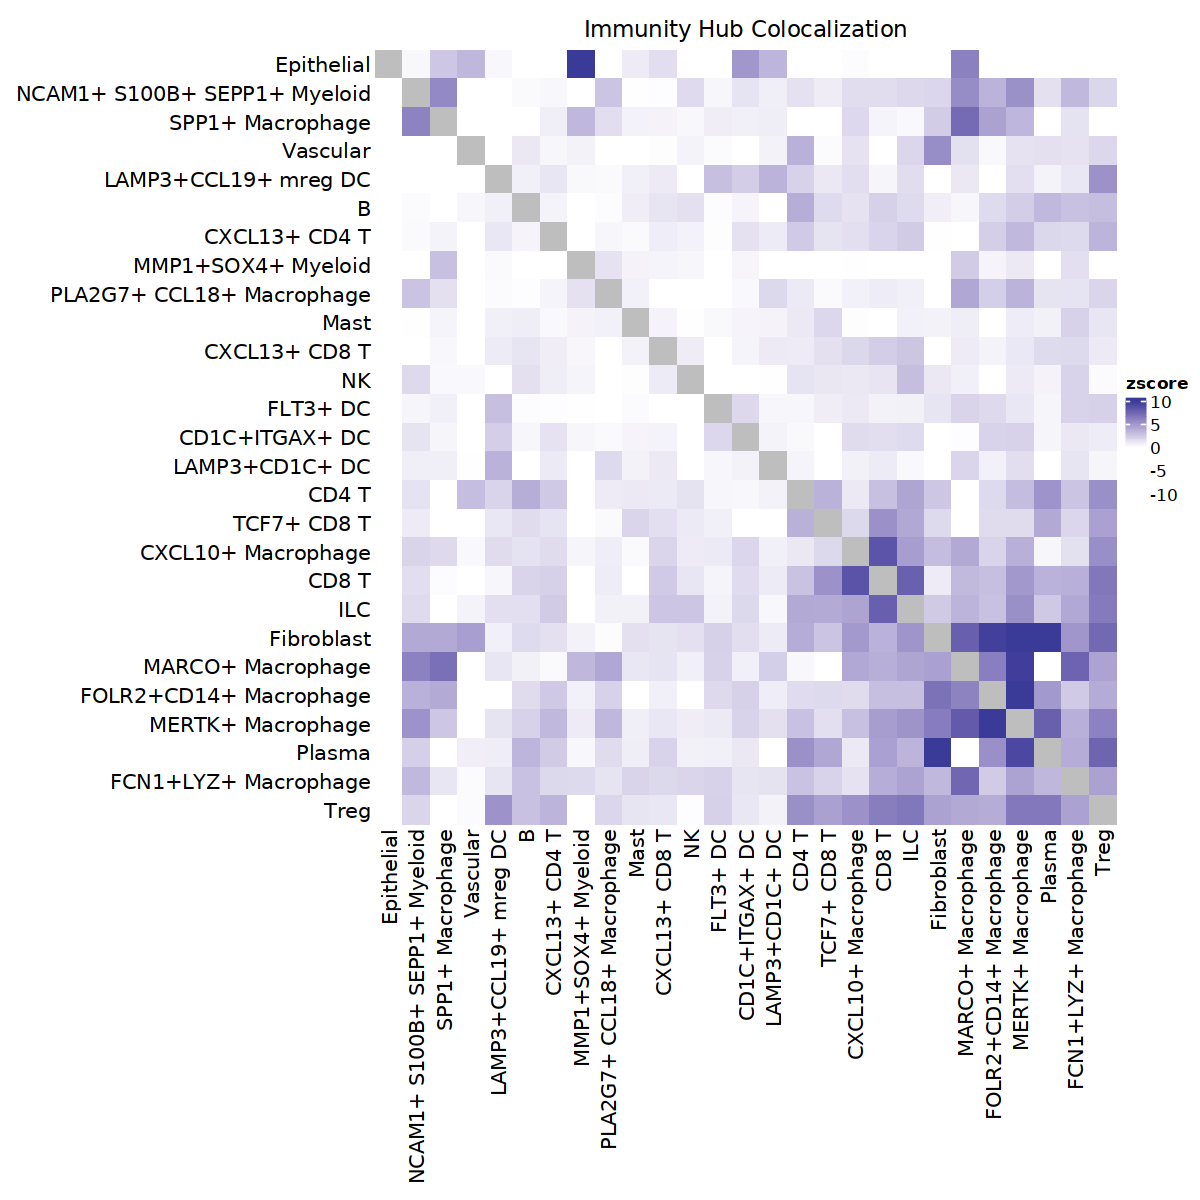

In [123]:
fig.size(10, 10)
X = res_meta[hubType == 'immune_hub'][, .(index_type, type, zscore)] %>%
    data.frame() %>% 
    tidyr::spread(type, zscore, fill = NA) %>% 
    tibble::column_to_rownames('index_type') %>% 
    as.matrix() 

X = pmin(X, 10)
o = hclust(dist(X))$order

plt = Heatmap(
    matrix = X[o, o], 
    cluster_columns = FALSE, cluster_rows = FALSE, 
    name = 'zscore',
    col = colorRamp2(c(-10, 0, 10), c('white', 'white', muted('blue'))),
    column_title = 'Immunity Hub Colocalization',
    row_names_side = 'left'
)

plt <- grid.grabExpr(
    draw(
        plt, 
        padding = unit(c(15, 15, 2, 2), "mm"), #bottom, left, top, right paddings
    )    
) 
plt <- wrap_elements(plt)
plt


In [32]:
fwrite(res_meta, '/n/data1/bwh/medicine/korsunsky/lab/ik97/NirMerfish/data/colocalization_stats_meta_v3.csv')
